# Redrock Residuals

Example of how to:
1. Read in spectra.
2. Coadd the cameras.
3. Access the redrock best fits and template coefficients.
4. Resample the best fit template and compute the residual flux.

Based closely on the [redrock outputs notebook](https://github.com/desihub/tutorials/blob/master/redrock/RedrockOutputs.ipynb) in the desihub tutorials.

In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from glob import glob

from desispec.io import findfile
from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra
from desispec.coaddition import coadd_cameras
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

from desitarget.cmx.cmx_targetmask import cmx_mask

from astropy.table import Table, vstack, hstack

import redrock.templates

import fitsio

In [2]:
mpl.rc('font', size=14)

## Access Data

Nightly pipeline reduction is in the location `${DESI_SPECTRO_REDUX}/daily`; Andes offline reprocessing is in `${DESI_SPECTRO_REDUX}/andes`.

One could access tile and night data using `desispec.io.findfile` but it's just as easy to glob in the folders to see what's there.

In [3]:
specprod = 'andes' # daily
tile='66000'
night='20200314'

zbest = '/'.join([os.environ['DESI_SPECTRO_REDUX'], specprod, 'tiles', tile, night, 'zbest*.fits'])
zbfiles = sorted(glob(zbest))

coadd = '/'.join([os.environ['DESI_SPECTRO_REDUX'], specprod, 'tiles', tile, night, 'coadd*.fits'])
cafiles = sorted(glob(coadd))

In [4]:
zbfiles

['/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-0-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-1-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-2-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-3-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-4-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-5-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-6-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-7-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-8-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/zbest-9-66000-20200314.fits']

In [5]:
cafiles

['/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-0-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-1-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-2-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-3-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-4-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-5-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-6-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-7-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-8-66000-20200314.fits',
 '/global/cfs/cdirs/desi/spectro/redux/andes/tiles/66000/20200314/coadd-9-66000-20200314.fits']

### Check for BGS Targets

In [6]:
cmx_bgs_bits = '|'.join([_ for _ in cmx_mask.names() if 'BGS' in _])
cmx_bgs_bits

'SV0_BGS|MINI_SV_BGS_BRIGHT'

## Extract and Co-add Spectra

As of the Andes reprocessing, the coadd FITS files contain coadds across exposures, but not per camera. To get the three spectrograph arms coadded into one (as in the spectra viewed in the prospect tool) one must call `desispec.coaddition.coadd_cameras`.

In [7]:
# Loop through zbest and coadd files for each petal.
# Extract the fibermaps, ZBEST tables, and spectra.
# Keep only BGS targets passing basic event selection.
allzbest = None
allfmap = None
allwave = None
allflux = None
allivar = None
allmask = None
allres  = None

for cafile, zbfile in zip(cafiles, zbfiles):
    # Access data per petal.
    zbest = Table.read(zbfile, 'ZBEST')
    pspectra = read_spectra(cafile)      # coadded exposures, separate cameras
    cspectra = coadd_cameras(pspectra)   # coadd B, R, Z
    fibermap = cspectra.fibermap

    # Apply standard event selection.
    isTGT = fibermap['OBJTYPE'] == 'TGT'
    isGAL = zbest['SPECTYPE'] == 'GALAXY'
    isBGS = fibermap['CMX_TARGET'] & cmx_mask.mask(cmx_bgs_bits) != 0
    select = isTGT & isBGS

    # Accumulate spectrum data.
    if allzbest is None:
        allzbest = zbest[select]
        allfmap = fibermap[select]
        allwave = cspectra.wave['brz']
        allflux = cspectra.flux['brz'][select]
        allivar = cspectra.ivar['brz'][select]
        allmask = cspectra.mask['brz'][select]
        allres  = cspectra.resolution_data['brz'][select]
    else:
        allzbest = vstack([allzbest, zbest[select]])
        allfmap = vstack([allfmap, fibermap[select]])
        allflux = np.vstack([allflux, cspectra.flux['brz'][select]])
        allivar = np.vstack([allivar, cspectra.ivar['brz'][select]])
        allmask = np.vstack([allmask, cspectra.mask['brz'][select]])
        allres  = np.vstack([allres, cspectra.resolution_data['brz'][select]])

In [8]:
allzbest['SPECTYPE', 'Z']

SPECTYPE,Z
bytes6,float64
STAR,-0.0019957014509158224
GALAXY,0.4127602238362079
STAR,-0.0019957014509158224
GALAXY,0.47986652717840383
GALAXY,0.23215950994590887
GALAXY,0.3038436607456414
GALAXY,0.012817679899275626
GALAXY,0.16961511981712682
GALAXY,0.3038969732303548


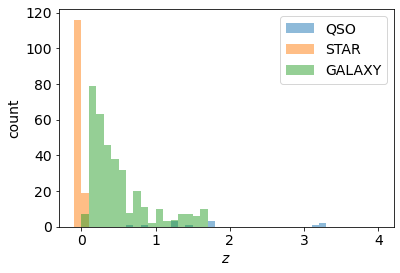

In [9]:
for spectype in set(zbest['SPECTYPE']):
    ii = (zbest['SPECTYPE'] == spectype)
    plt.hist(zbest['Z'][ii], 41, (-0.1,4), label=spectype.strip(), alpha=0.5)
plt.xlabel('$z$')
plt.ylabel('count')
plt.legend();

## Apply Redrock Best Fit

### Load Redrock Templates

In [10]:
templates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    templates[(t.template_type, t.sub_type)] = t

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20190804-1.3.0-spec/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


### Cut on Redshift Fit Quality

In [11]:
goodBGS = (allzbest['SPECTYPE'] == 'GALAXY') & (allzbest['Z'] < 0.5)
goodBGS &= (allzbest['ZWARN'] == 0) & (allzbest['DELTACHI2']>100)
np.sum(goodBGS)

2207

### Extract One Spectrum and Plot the Template

Grab the best-fit redrock template for one of the galaxy spectra.

In [12]:
i = np.where(goodBGS)[0][3]
z = allzbest['Z'][i]
targetid = allzbest['TARGETID'][i]
spectype = allzbest['SPECTYPE'][i].strip()
subtype = allzbest['SUBTYPE'][i].strip()
fulltype = (spectype, subtype)
ncoeff = templates[fulltype].flux.shape[0]
coeff = allzbest['COEFF'][i][0:ncoeff]

In [13]:
tflux = templates[fulltype].flux.T.dot(coeff)
twave = templates[fulltype].wave * (1 + z)

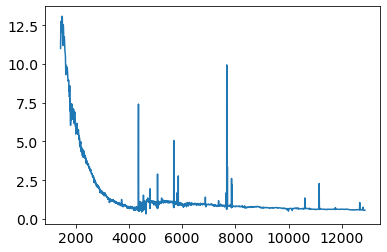

In [14]:
plt.plot(twave, tflux)

### Downsample the Template and Compute Fit Residuals

As described in the [RedrockOutputs tutorial](https://github.com/desihub/tutorials/blob/master/redrock/RedrockOutputs.ipynb), the redrock templates are high resolution before any instrumental resolution is applied. Downsample to use the spectral resolution of the data.

In [15]:
R = Resolution(cspectra.resolution_data['brz'][i])
txflux = R.dot(resample_flux(cspectra.wave['brz'], twave, tflux))

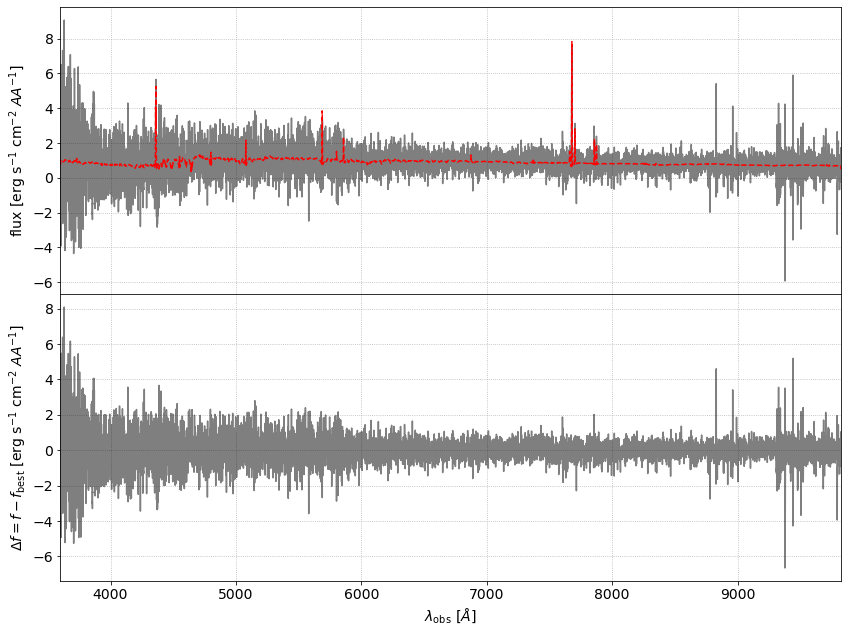

In [16]:
fig, axes = plt.subplots(2,1, figsize=(12,9), sharex=True, tight_layout=True, gridspec_kw={'hspace':0})

ax = axes[0]
ax.plot(allwave, allflux[i], color='k', alpha=0.5)
ax.plot(allwave, txflux, 'r--')
ax.set(ylabel=r'flux [erg s$^{-1}$ cm$^{-2}$ $AA^{-1}$]')
ax.grid(ls=':')

ax = axes[1]
ax.plot(allwave, allflux[i] - txflux, color='k', alpha=0.5)
ax.set(xlabel=r'$\lambda_\mathrm{obs}$ [$\AA$]',
       xlim=(allwave[0], allwave[-1]),
       ylabel=r'$\Delta f=f-f_\mathrm{best}$ [erg s$^{-1}$ cm$^{-2}$ $AA^{-1}$]')
ax.grid(ls=':')

fig.savefig('redrock_example.png', dpi=100)